# Investigating Amount of Necessary Real-World Data for Road-Following Tasks

#### Imports

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import os
import importlib
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import image_dataset

importlib.reload(image_dataset)

from image_dataset import ImageSteeringAngleDataset, load_real_data, load_sim_data, shuffle_real_sim_data
from model import NeighborhoodRealCNN
from utils_graphs import plot_two_datasets, plot_model_sim_output, plot_loss_curve
import torchvision.transforms as transforms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Hyperparameters

In [45]:
sim_ratio = 0.5
data_sim_dir = "C:/Users/Cleah/Documents/AirSim/"
data_real_dir = "C:\\Users\\Cleah\\Documents\\Projects\\University Research\\Robot Learning Lab\\Simulator\\airsim-car-experiments\\PythonClient\\reinforcement_learning\\balanced_data_split\\"
model_dir = "realOnSim.pth"

batch_size = 2
epochs = 30
learning_rate = 0.0001
momentum = 0.9

#### Data Loading

In [41]:
# Load data. 
# Specify ratio of real:sim. 1 - sim_ratio = real_ratio
sim_ratio = 0.1

data_real_list = [f"{data_real_dir}"]
data_sim_list =[f"{data_sim_dir}2023-07-20-12-44-49",
                f"{data_sim_dir}2023-07-20-15-11-35",
                f"{data_sim_dir}2023-08-31-12-43-09",
                f"{data_sim_dir}2023-08-31-17-38-56",
                f"{data_sim_dir}2023-08-31-17-46-35",
                f"{data_sim_dir}2023-08-31-17-58-47",
                f"{data_sim_dir}2023-08-31-18-25-48",
                f"{data_sim_dir}2023-08-31-18-38-10",
                f"{data_sim_dir}2023-09-05-10-46-44",
                f"{data_sim_dir}2023-09-05-17-52-22",
                f"{data_sim_dir}2023-09-05-18-15-04",
                f"{data_sim_dir}2023-09-07-11-39-09",
                f"{data_sim_dir}2023-09-08-08-26-58",
                f"{data_sim_dir}2023-09-08-08-33-30",
                f"{data_sim_dir}2023-09-08-08-43-51",
                f"{data_sim_dir}2023-09-08-09-37-12",
                f"{data_sim_dir}2023-09-08-11-44-53",
                f"{data_sim_dir}2023-09-08-11-49-02",
                f"{data_sim_dir}2023-09-08-11-53-42",
                f"{data_sim_dir}2023-09-08-11-55-47",
                f"{data_sim_dir}2023-09-12-10-26-49"
            ]

real_data = load_real_data(data_real_list)
sim_data = load_sim_data(data_sim_list)
print(f"Sim images lenght {sim_data[0].shape} and sa {sim_data[1].shape}")
print(f"Real images lenght {real_data[0].shape} and sa {real_data[1].shape}")


shuffled_real_sim_data = shuffle_real_sim_data(real_data, sim_data, sim_ratio)
# print(f"combined imags: {torch.min(shuffled_real_sim_data[0][0]), torch.max(shuffled_real_sim_data[0][0])}")

dataset = ImageSteeringAngleDataset(shuffled_real_sim_data[0], shuffled_real_sim_data[1])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([815, 3, 144, 256])
real images: (tensor(-2.1644, dtype=torch.float64), tensor(2.5241, dtype=torch.float64))
Steering angle tensor shape: torch.Size([5382, 1])
Sim images lenght torch.Size([5382, 3, 144, 256]) and sa torch.Size([5382, 1])
Real images lenght torch.Size([815, 3, 144, 256]) and sa torch.Size([815, 1])
5382 815 815


#### Train

Epoch 0
Running Loss 2.307019756897467
Epoch 1
Running Loss 2.073337707221143
Epoch 2
Running Loss 1.9397748947901396
Epoch 3
Running Loss 1.7843715555180668
Epoch 4
Running Loss 1.6935258035036718
Epoch 5
Running Loss 1.5385845674900338
Epoch 6
Running Loss 1.4427283536711268
Epoch 7
Running Loss 1.2844048798524812
Epoch 8
Running Loss 1.1701514804187942
Epoch 9
Running Loss 1.0384296391538217
Epoch 10
Running Loss 0.9368173337504998
Epoch 11
Running Loss 0.8216039581890857
Epoch 12
Running Loss 0.7375384466734021
Epoch 13
Running Loss 0.643939594764436
Epoch 14
Running Loss 0.5550266196449086
Epoch 15
Running Loss 0.4558962688737951
Epoch 16
Running Loss 0.41033956916619313
Epoch 17
Running Loss 0.35121433048876566
Epoch 18
Running Loss 0.33637065534005123
Epoch 19
Running Loss 0.2794045510909557
Epoch 20
Running Loss 0.23764755654687464
Epoch 21
Running Loss 0.2155181026213469
Epoch 22
Running Loss 0.18724926251589374
Epoch 23
Running Loss 0.17204544419313178
Epoch 24
Running Loss 0

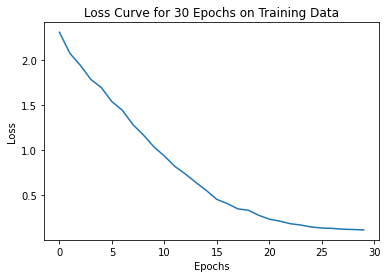

In [46]:
# Loads model
cnn = NeighborhoodRealCNN()

# Optimizer
loss = nn.MSELoss()
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate, momentum=momentum)

running_losses_list = []
for epoch in range(epochs):  # loop over the dataset epoch times
    running_loss = 0.0
    print(f"Epoch {epoch}")
    for i, data in enumerate(dataloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        image, steering_angle = data
        # print(torch.min(image[0]), torch.max(image[0]))
        # assert False
        # print(f"steering_angle {steering_angle}")
        image, steering_angle = image.float(), steering_angle.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = cnn(image)
        loss_out = loss(outputs, steering_angle)
        loss_out.backward()
        optimizer.step()
        running_loss += loss_out.item()
    
    print(f"Running Loss {running_loss / len(dataloader)}")
    running_losses_list.append(float(running_loss / len(dataloader)))

print('Finished Training')

# Plot train losses
plot_loss_curve(running_losses_list, epochs)

torch.save(cnn, model_dir)

#### Evaluate